### Prereq
The following functionalities are provided out of the box:
1. draw_dot
2. sample inputs to validate the Value Class 

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [17]:
# Simple neurons can be represented by squash_func(x1w1 + x2w2 + b (bias))

# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.8813735870195432, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [5]:
#### --- prereqs end here -------- ####

In [6]:
import math
import random

In [15]:
class Value:
    def __init__(self, data, label='', _children=(), _op='', grad = 0, _backward = lambda: None):
        self.data = data
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self.grad = grad
        self._backward = _backward

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        
        return out

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, _children = (self, other), _op= '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        x = (math.exp(2 * self.data) - 1)/ (math.exp(2 * self.data) + 1)
        out = Value(x, _children = (self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - (out.data ** 2))
        out._backward = _backward
        return out
        
        

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        for node in reversed(topo):
            node._backward()

    

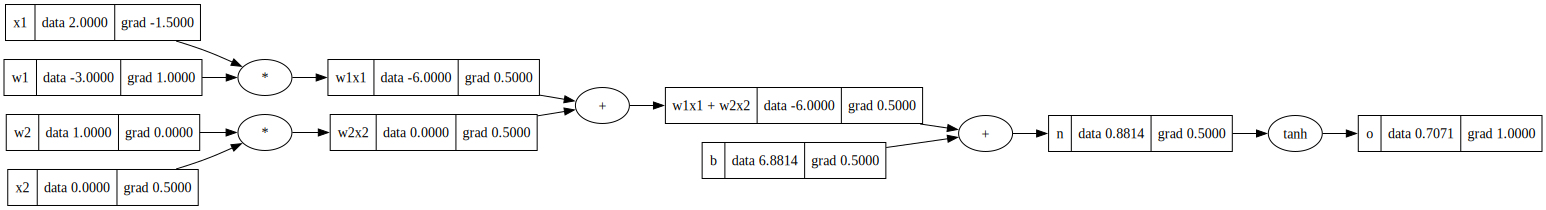

In [18]:
o.grad = 1.0
o.backward()
draw_dot(o)

In [19]:
class Neuron:
    # nin is the number of inputs to the neuron
    def __init__(self, nin):
        # generate weights & bias
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = random.uniform(-1, 1)

    def __call__(self, x):
        # x will be a [x1, x2..]
        # need to return activation_func((w1x1 + w2x2) + b)
        dp = sum((xi * wi for xi, wi in zip(x, self.w)))
        return (dp + self.b).tanh()

In [20]:
class Layer:
    # nin: number of inputs
    # nout: number of neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out if len(out) > 1 else out[0] 

In [21]:
class MLP:
    # nin: number of inputs
    # nouts: list of layers where each layer will define how many neurons it has
    def __init__(self, nin, nouts):
        # This is to create a list where each pair of elements will represent inputs <> ouputs
        self.sz = [nin] + nouts
        self.layers = [Layer(self.sz[i], self.sz[i+1]) for i in range(0, len(self.sz) - 1)]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
        
        

In [22]:
m = MLP(3, [4, 4, 1])

In [23]:
x = [1.0, 2.0, -3.0]

In [24]:
m(x)

Value(data=0.9056293300156114)